In [3]:
import scikitplot as skplt
import matplotlib.pyplot as plt

In [1]:
def get_input_for_embedding(fasta_file):
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        for char in data:
            if char not in alphabet:
                return
        integer_encoded = [char_to_int[char] for char in data]
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    return encodings

In [2]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Input, LeakyReLU, Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from Bio import SeqIO
from keras import backend as K
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve

# load test data
train_positive_pt5 = pd.read_csv("data/DeepSuccinylSite/features/full/train_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
train_negative_pt5 = pd.read_csv("data/DeepSuccinylSite/features/full/train_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_positive_pt5 = pd.read_csv("data/DeepSuccinylSite/features/full/test_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_negative_pt5 = pd.read_csv("data/DeepSuccinylSite/features/full/test_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]

# create labels
train_positive_labels = np.ones(train_positive_pt5.shape[0])
train_negative_labels = np.zeros(train_negative_pt5.shape[0])
test_positive_labels = np.ones(test_positive_pt5.shape[0])
test_negative_labels = np.zeros(test_negative_pt5.shape[0])

# stack positive and negative data together
X_train_pt5 = np.vstack((train_positive_pt5,train_negative_pt5))
X_test_pt5 = np.vstack((test_positive_pt5,test_negative_pt5))
y_train_pt5 = np.concatenate((train_positive_labels, train_negative_labels), axis = 0)
y_test_pt5 = np.concatenate((test_positive_labels, test_negative_labels), axis = 0)

# shuffle X and y together
# X_train_pt5, y_train_pt5 = shuffle(X_train_pt5, y_train_pt5)
# X_test_pt5, y_test_pt5 = shuffle(X_test_pt5, y_test_pt5)

# convert sequences to integer encoding, for embedding
test_positive_embedding = get_input_for_embedding('data/DeepSuccinylSite/fasta/test_positive_sites.fasta')
test_negative_embedding = get_input_for_embedding('data/DeepSuccinylSite/fasta/test_negative_sites.fasta')
train_positive_embedding = get_input_for_embedding('data/DeepSuccinylSite/fasta/positive_sites.fasta')
train_negative_embedding = get_input_for_embedding('data/DeepSuccinylSite/fasta/negative_sites.fasta')

# stack positive and negative data together
X_train_full_embedding = np.vstack((train_positive_embedding,train_negative_embedding))
X_test_embedding = np.vstack((test_positive_embedding,test_negative_embedding))

2022-09-06 14:56:47.171284: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-06 14:56:47.177291: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 14:56:47.177304: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/suresh/anaconda3/envs/bio/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
y_test_pt5.shape

(507,)

In [5]:
def CNN_1D():
    model = Sequential()
    model.add(Input(shape=(1024,1)))
    model.add(Conv1D(filters=64,kernel_size=3,activation='relu',name='Conv_1D_1_add'))
    model.add(MaxPooling1D(pool_size=2,name="MaxPooling1D"))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(16,activation='relu',name="Dense_1"))
    model.add(Dropout(0.4))
    model.add(Dense(1,activation='sigmoid',name="Dense_2"))
    return model

In [6]:
# load pretrained models
ANN_model = load_model('ROC/ANN.h5')
Embedding_model = load_model('ROC/Embedding.h5')
Embedding_LSTM_Model = load_model("selected_models/embedding_lstm_1.h5")
combined_model = load_model('selected_models/combined_feature_level_3626.h5')

2022-08-08 12:47:45.121758: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-08 12:47:45.121882: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-08-08 12:47:45.121971: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-08-08 12:47:45.125034: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-08-08 12:47:45.125138: W tensorflow/stream_executor/platform/default/dso_loader

### Train or Import Models

In [76]:

#CNN 1D
model_cnn_1d = CNN_1D()
model_cnn_1d.compile(optimizer=Adam(learning_rate=1e-3),
          loss=BinaryCrossentropy(),
          metrics=['accuracy'])
metric = 'val_accuracy'
history = model_cnn_1d.fit(X_train_pt5, y_train_pt5, epochs=30, verbose=1)

Epoch 1/30
297/297 [==============================] - 4s 13ms/step - loss: 0.6440 - accuracy: 0.6176
Epoch 2/30
297/297 [==============================] - 4s 13ms/step - loss: 0.5936 - accuracy: 0.6690
Epoch 3/30
297/297 [==============================] - 4s 13ms/step - loss: 0.5698 - accuracy: 0.6848
Epoch 4/30
297/297 [==============================] - 4s 13ms/step - loss: 0.5507 - accuracy: 0.6962
Epoch 5/30
297/297 [==============================] - 4s 13ms/step - loss: 0.5373 - accuracy: 0.7005
Epoch 6/30
297/297 [==============================] - 4s 13ms/step - loss: 0.5221 - accuracy: 0.7103
Epoch 7/30
297/297 [==============================] - 4s 13ms/step - loss: 0.5132 - accuracy: 0.7164
Epoch 8/30
297/297 [==============================] - 4s 13ms/step - loss: 0.5033 - accuracy: 0.7145
Epoch 9/30
297/297 [==============================] - 4s 13ms/step - loss: 0.4910 - accuracy: 0.7249
Epoch 10/30
297/297 [==============================] - 4s 13ms/step - loss: 0.4820 - accura

In [10]:
# RF
rf_clf = RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_split=5, n_estimators=10)
rf_clf.fit(X_train_pt5, y_train_pt5)

# SVM
svm_clf = SVC(C = 3, gamma = 0.01, kernel = 'rbf', probability=True)
svm_clf.fit(X_train_pt5, y_train_pt5)

#XGB
xgb_clf = xgb.XGBRegressor(seed = 321, max_depth =  10, learning_rate = 0.01, n_estimators = 100, colsample_bytree = 0.3)
xgb_clf.fit(X_train_pt5, y_train_pt5)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=32,
             num_parallel_tree=1, predictor='auto', random_state=321,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=321,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

# ROCAUC Curves

### Prot T5 Based Models

16/16 [==============================] - 0s 4ms/step


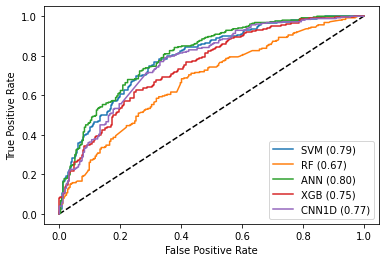

In [77]:
plt.plot([0,1],[0,1], 'k--')

# model_1
y_pred_ANN = ANN_model.predict(X_test_pt5)
fpr_ANN , tpr_ANN, thresholds_ANN = roc_curve(y_test_pt5, y_pred_ANN)
auc_score = roc_auc_score(y_test_pt5, y_pred_ANN)
plt.plot(fpr_ANN, tpr_ANN, label= "SVM ({:.2f})".format(auc_score))

# model_4
y_pred_rf = rf_clf.predict_proba(X_test_pt5)
y_pred_rf = [e[1] for e in y_pred_rf]
fpr_rf , tpr_rf, thresholds_rf = roc_curve(y_test_pt5, y_pred_rf)
auc_score = roc_auc_score(y_test_pt5, y_pred_rf)
plt.plot(fpr_rf, tpr_rf, label= "RF ({:.2f})".format(auc_score))

# model_5
y_pred_svm = svm_clf.predict_proba(X_test_pt5)
y_pred_svm = [e[1] for e in y_pred_svm]
fpr_svm , tpr_svm, thresholds_svm = roc_curve(y_test_pt5, y_pred_svm)
auc_score = roc_auc_score(y_test_pt5, y_pred_svm)
plt.plot(fpr_svm, tpr_svm, label= "ANN ({:.2f})".format(auc_score))

# model_6
y_pred_xgb = xgb_clf.predict(X_test_pt5)
fpr_xgb , tpr_xgb, thresholds_xgb = roc_curve(y_test_pt5, y_pred_xgb)
auc_score = roc_auc_score(y_test_pt5, y_pred_xgb)
plt.plot(fpr_xgb, tpr_xgb, label= "XGB ({:.2f})".format(auc_score))

# model_7
y_pred_cnn1d = model_cnn_1d.predict(X_test_pt5).reshape(y_test_pt5.shape[0],)
fpr_cnn1d , tpr_cnn1d, thresholds_cnn1d = roc_curve(y_test_pt5, y_pred_cnn1d)
auc_score = roc_auc_score(y_test_pt5, y_pred_cnn1d)
plt.plot(fpr_cnn1d, tpr_cnn1d, label= "CNN1D ({:.2f})".format(auc_score))

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title('Receiver Operating Characteristic')
plt.savefig('ROC-ProtT5-Models.png', dpi = 600)
plt.show()


### Embedding Based Models

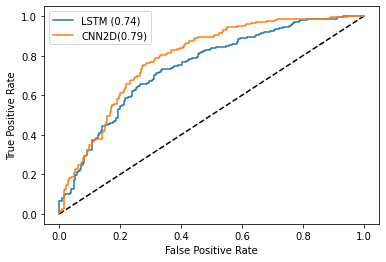

In [15]:
plt.plot([0,1],[0,1], 'k--')

#model_2
y_pred_embedding_lstm = Embedding_LSTM_Model(X_test_embedding)
fpr_embedding_lstm , tpr_embedding_lstm, thresholds_embedding_lstm = roc_curve(y_test_pt5, y_pred_embedding_lstm)
auc_score  = roc_auc_score(y_test_pt5, y_pred_embedding_lstm)
plt.plot(fpr_embedding_lstm , tpr_embedding_lstm, label= "LSTM ({:.2f})".format(auc_score ))

#model_2
y_pred_embedding = Embedding_model(X_test_embedding)
fpr_embedding , tpr_embedding, thresholds_embedding = roc_curve(y_test_pt5, y_pred_embedding)
auc_score = roc_auc_score(y_test_pt5, y_pred_embedding)
plt.plot(fpr_embedding , tpr_embedding, label= "CNN2D({:.2f})".format(auc_score ))

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title('Receiver Operating Characteristic')
plt.savefig('Embedding_Based_Models.png', dpi = 600)
plt.show()


### Combined models

### Load second last layer features of final models to train SVM/RF/LR 

In [7]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


intermediate_features = pd.read_csv('new_features_intermediate.csv', header = None)
X_ensemble_full = intermediate_features[intermediate_features.columns[:-1]]
y_ensemble_full = intermediate_features[intermediate_features.columns[-1]]

X_ensemble_train, X_ensemble_val, y_ensemble_train, y_ensemble_val = train_test_split(X_ensemble_full, y_ensemble_full, test_size = 0.1, random_state = 321)

In [71]:
# train models
#RF
rf_meta = RandomForestClassifier()
rf_meta.fit(X_ensemble_train, y_ensemble_train)
y_pred_rf_meta = rf_meta.predict_proba(X_ensemble_val)
y_pred_rf_meta = [e[1] for e in y_pred_rf_meta]

#SVM
svm_meta = SVC(probability=True)
svm_meta.fit(X_ensemble_train, y_ensemble_train)
y_pred_svm_meta = svm_meta.predict_proba(X_ensemble_val)
y_pred_svm_meta = [e[1] for e in y_pred_svm_meta]

#XGB
xgb_meta = xgb.XGBRegressor(seed = 321, max_depth =  10, learning_rate = 0.01, n_estimators = 100, colsample_bytree = 0.3)
xgb_meta.fit(X_ensemble_train, y_ensemble_train)
y_pred_xgb_meta = xgb_meta.predict(X_ensemble_val)

#LR
lr_meta = LogisticRegression(random_state = 321).fit(X_ensemble_train, y_ensemble_train)
lr_meta.fit(X_ensemble_train, y_ensemble_train)
y_pred_lr_meta = xgb_meta.predict(X_ensemble_val)


/home/suresh/anaconda3/envs/bio/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


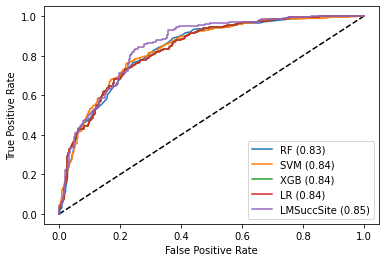

In [74]:
plt.plot([0,1],[0,1], 'k--')

# model_1
fpr_rf_meta , tpr_rf_meta, thresholds_rf_meta = roc_curve(y_ensemble_val, y_pred_rf_meta)
auc_score  = roc_auc_score(y_ensemble_val, y_pred_rf_meta)
plt.plot(fpr_rf_meta , tpr_rf_meta, label= "RF ({:.2f})".format(auc_score))

#model_2
fpr_svm_meta , tpr_svm_meta, thresholds_svm_meta = roc_curve(y_ensemble_val, y_pred_svm_meta)
auc_score = roc_auc_score(y_ensemble_val, y_pred_svm_meta)
plt.plot(fpr_svm_meta , tpr_svm_meta, label= "SVM ({:.2f})".format(auc_score))

#model_3
fpr_xgb_meta , tpr_xgb_meta, thresholds_xgb_meta = roc_curve(y_ensemble_val, y_pred_xgb_meta)
auc_score = roc_auc_score(y_ensemble_val, y_pred_xgb_meta)
plt.plot(fpr_xgb_meta, tpr_xgb_meta, label= "XGB ({:.2f})".format(auc_score))

#model_4
fpr_lr_meta , tpr_lr_meta, thresholds_lr_meta = roc_curve(y_ensemble_val, y_pred_lr_meta)
auc_score = roc_auc_score(y_ensemble_val, y_pred_lr_meta)
plt.plot(fpr_lr_meta, tpr_lr_meta, label= "LR ({:.2f})".format(auc_score))

# model_3
y_pred_combined_model = combined_model([X_test_embedding,X_test_pt5])
fpr_combined , tpr_combined, thresholds_combined = roc_curve(y_test_pt5, y_pred_combined_model)
auc_score  = roc_auc_score(y_test_pt5, y_pred_combined_model)
plt.plot(fpr_combined , tpr_combined, label= "LMSuccSite ({:.2f})".format(auc_score ))

plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title('Receiver Operating Characteristic')
plt.savefig('ROC-00.png', dpi = 600)
plt.show()


# PRAUC Curves

### ProtT5 based curves

16/16 [==============================] - 0s 4ms/step


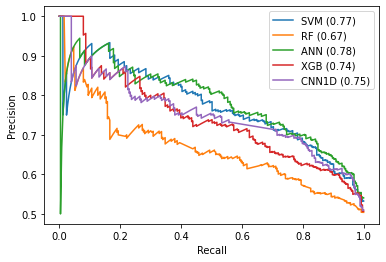

In [78]:
# model_1
y_pred_ANN = ANN_model.predict(X_test_pt5)
precision_ANN , recall_ANN, thresholds_ANN = precision_recall_curve(y_test_pt5, y_pred_ANN)
auc_score = auc(recall_ANN, precision_ANN)
plt.plot(recall_ANN, precision_ANN, label= "SVM ({:.2f})".format(auc_score))

# model_4
y_pred_rf = rf_clf.predict_proba(X_test_pt5)
y_pred_rf = [e[1] for e in y_pred_rf]
precision_rf , recall_rf, thresholds_rf = precision_recall_curve(y_test_pt5, y_pred_rf)
auc_score = auc(recall_rf, precision_rf)
plt.plot(recall_rf, precision_rf, label= "RF ({:.2f})".format(auc_score))

# model_5
y_pred_svm = svm_clf.predict_proba(X_test_pt5)
y_pred_svm = [e[1] for e in y_pred_svm]
precision_svm , recall_svm, thresholds_svm = precision_recall_curve(y_test_pt5, y_pred_svm)
auc_score = auc(recall_svm, precision_svm)
plt.plot(recall_svm, precision_svm, label= "ANN ({:.2f})".format(auc_score))

# model_6
y_pred_xgb = xgb_clf.predict(X_test_pt5)
precision_xgb , recall_xgb, thresholds_xgb = precision_recall_curve(y_test_pt5, y_pred_xgb)
auc_score = auc(recall_xgb, precision_xgb)
plt.plot(recall_xgb, precision_xgb, label= "XGB ({:.2f})".format(auc_score))

# model_7
y_pred_cnn1d = model_cnn_1d.predict(X_test_pt5).reshape(y_test_pt5.shape[0],)
precision_cnn1d , recall_cnn1d, thresholds_cnn1d = precision_recall_curve(y_test_pt5, y_pred_cnn1d)
auc_score = auc(recall_cnn1d, precision_cnn1d)
plt.plot(recall_cnn1d, precision_cnn1d, label= "CNN1D ({:.2f})".format(auc_score))

plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.savefig('PRC-ProtT5-Models.png', dpi = 600)
plt.show()


### Embedding Based Models

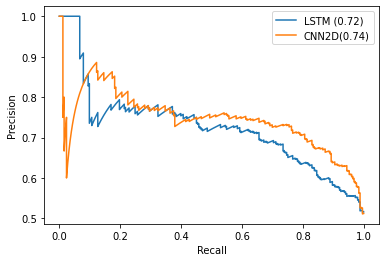

In [8]:
#model_2
y_pred_embedding_lstm = Embedding_LSTM_Model(X_test_embedding)
precision_embedding_lstm , recall_embedding_lstm, thresholds_embedding_lstm = precision_recall_curve(y_test_pt5, y_pred_embedding_lstm)
auc_score  = auc(recall_embedding_lstm, precision_embedding_lstm)
plt.plot(recall_embedding_lstm,precision_embedding_lstm, label= "LSTM ({:.2f})".format(auc_score ))

#model_2
y_pred_embedding = Embedding_model(X_test_embedding)
precision_embedding , recall_embedding, thresholds_embedding = precision_recall_curve(y_test_pt5, y_pred_embedding)
auc_score = auc(recall_embedding, precision_embedding)
plt.plot(recall_embedding, precision_embedding ,label= "CNN2D({:.2f})".format(auc_score ))

plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.savefig('PRC-Embedding_Based_Models.png', dpi = 600)
plt.show()


### Combined models

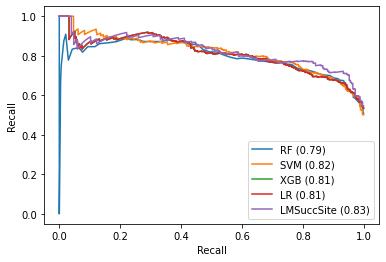

In [86]:
# model_1
precision_rf_meta , recall_rf_meta, thresholds_rf_meta = precision_recall_curve(y_ensemble_val, y_pred_rf_meta)
auc_score  = auc(recall_rf_meta, precision_rf_meta)
plt.plot(recall_rf_meta, precision_rf_meta , label= "RF ({:.2f})".format(auc_score))

#model_2
precision_svm_meta , recall_svm_meta, thresholds_svm_meta = precision_recall_curve(y_ensemble_val, y_pred_svm_meta)
auc_score = auc(recall_svm_meta, precision_svm_meta)
plt.plot(recall_svm_meta, precision_svm_meta ,label= "SVM ({:.2f})".format(auc_score))

#model_3
precision_xgb_meta , recall_xgb_meta, thresholds_xgb_meta = precision_recall_curve(y_ensemble_val, y_pred_xgb_meta)
auc_score = auc(recall_xgb_meta, precision_xgb_meta)
plt.plot(recall_xgb_meta, precision_xgb_meta, label= "XGB ({:.2f})".format(auc_score))

#model_4
precision_lr_meta , recall_lr_meta, thresholds_lr_meta = precision_recall_curve(y_ensemble_val, y_pred_lr_meta)
auc_score = auc(recall_lr_meta, precision_lr_meta)
plt.plot(recall_lr_meta, precision_lr_meta, label= "LR ({:.2f})".format(auc_score))

# model_3
y_pred_combined_model = combined_model([X_test_embedding,X_test_pt5])
precision_combined , recall_combined, thresholds_combined = precision_recall_curve(y_test_pt5, y_pred_combined_model)
auc_score  = auc(recall_combined, precision_combined)
plt.plot(recall_combined, precision_combined ,label= "LMSuccSite ({:.2f})".format(auc_score ))

plt.legend()
plt.xlabel("Recall")
plt.ylabel("Recall")
plt.savefig('PRC-Meta Classifier.png', dpi = 600)
plt.show()
